In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Imorting dataset from kaggle

In [ ]:
# generating dataset from directory

# Generating train dataset
data = tf.keras.utils.image_dataset_from_directory(directory = '/content/drive/MyDrive/shagundeep/dataset/Normal_Cataract/',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)

Found 2112 files belonging to 2 classes.


In [ ]:
labels = np.concatenate([y for x,y in data], axis=0)
values = pd.value_counts(labels)
values = values.sort_index()

In [ ]:
# getting class names
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = cataract, 1 = normal, 

#Visualizing the data

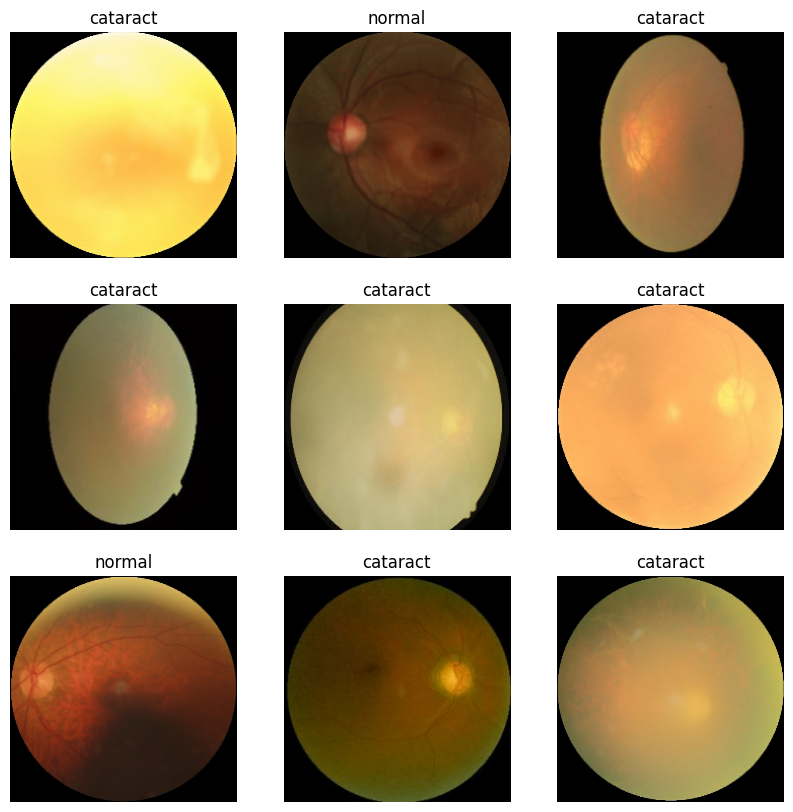

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Preprocessing data

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
# sns.heatmap(batch[0][1][:,:,1])

In [ ]:
sample = data.as_numpy_iterator().next()

In [ ]:
print("Minimum value of the scaled data:", sample[0].min())
print("Maximum value of the scaled data:", sample[0].max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


In [ ]:
print("There are", len(data), "batches in our data")

There are 33 batches in our data


Splitting the dataset

In [ ]:
train_size = int(len(data)*0.70)+1
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)
print("Train Size:", train_size)
print("Validation Size:", val_size)
print("Test Size:", test_size)


Train Size: 24
Validation Size: 6
Test Size: 3


In [ ]:
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

Preparing the dataset

In [ ]:
test_iter = test.as_numpy_iterator()
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
  try:
    batch = test_iter.next()
    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
  except:
    break

In [ ]:
y_true = test_set['labels']

DenseNET Model

In [ ]:
base_model = tf.keras.applications.densenet.DenseNet121(include_top=True,
                                            input_shape=(224,224)+(3,),
                                            weights= 'imagenet')
model = Sequential()
# model.add(data_augmentation)
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation='softmax'))

model.layers[0].trainable = False


33188688/33188688 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1000)              8062504   
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 8,068,506
Trainable params: 4,002
Non-trainable params: 8,064,504
__________________________________________

In [ ]:
history = model.fit(
    train,
    validation_data=val,
    epochs = 100,
    # callbacks = EarlyStopping(monitor='loss', patience=5)
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - 38s 778ms/step - loss: 0.6751 - accuracy: 0.6009 - val_loss: 0.6890 - val_accuracy: 0.5182
Epoch 2/100
24/24 [==============================] - 20s 775ms/step - loss: 0.6027 - accuracy: 0.7865 - val_loss: 0.6739 - val_accuracy: 0.7656
Epoch 3/100
24/24 [==============================] - 20s 762ms/step - loss: 0.5508 - accuracy: 0.8151 - val_loss: 0.6592 - val_accuracy: 0.8672
Epoch 4/100
24/24 [==============================] - 20s 765ms/step - loss: 0.5132 - accuracy: 0.8145 - val_loss: 0.6405 - val_accuracy: 0.8359
Epoch 5/100
24/24 [==============================] - 20s 758ms/step - loss: 0.4746 - accuracy: 0.8581 - val_loss: 0.6240 - val_accuracy: 0.8932
Epoch 6/100
24/24 [==============================] - 20s 754ms/step - loss: 0.4402 - accuracy: 0.8483 - val_loss: 0.6139 - val_accuracy: 0.7969
Epoch 7/100
24/24 [==============================] - 20s 759ms/step - loss: 0.4193 - accuracy: 0.8561 - val_loss: 0.5859 - val_accuracy: 0.8776
Epoc

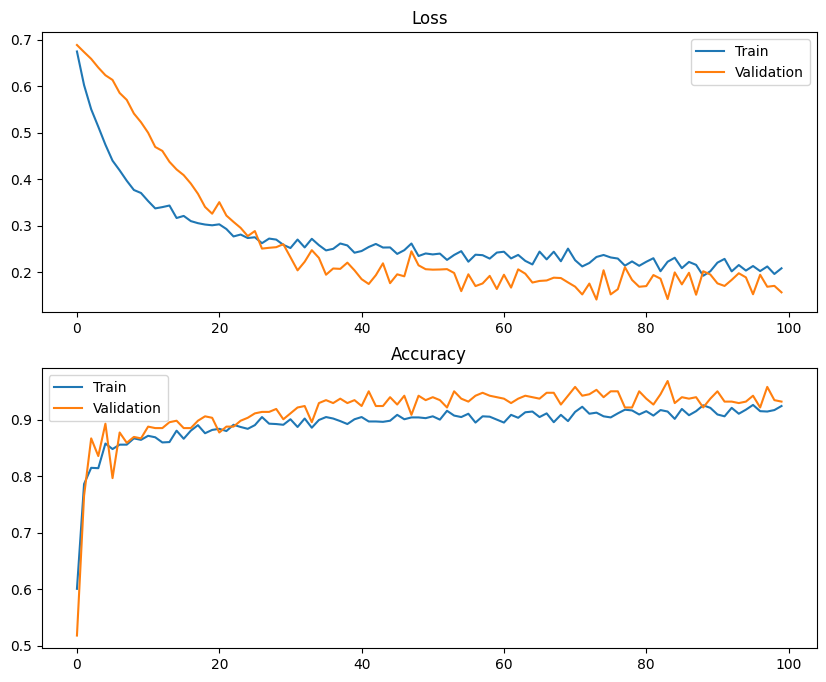

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(history.history["loss"], label="Train")
ax[0].plot(history.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="Train")
ax[1].plot(history.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()


In [ ]:
y_true

array([1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 1.])

In [ ]:

y_pred = np.argmax(model.predict(test_set['images']), 1)

6/6 [==============================] - 4s 80ms/step


In [ ]:
y_pred

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1])

In [ ]:
#y_pred_prob = np.argmax(model.predict_proba(test_set['images']), 1)

def predict_prob(number):
  return [number[0],1-number[0]]

y_prob = np.array(list(map(predict_prob, model.predict(test_set['images']))))
y_prob = y_prob[::,1]
y_prob

6/6 [==============================] - 0s 91ms/step


array([7.42417485e-01, 9.70407214e-01, 2.39928365e-01, 7.99286366e-03,
       9.21982192e-01, 7.45601654e-02, 6.11473531e-01, 8.91724229e-01,
       8.55431557e-02, 8.84637214e-01, 2.94176936e-02, 9.87747015e-01,
       2.00228691e-02, 4.48322535e-01, 1.84283853e-01, 1.62429869e-01,
       9.90191775e-01, 8.95194955e-01, 1.15770102e-03, 9.98337365e-01,
       9.90714607e-01, 7.30931759e-04, 9.89890282e-01, 3.28392804e-01,
       2.51139343e-01, 7.80044168e-01, 8.08179379e-04, 9.66828670e-01,
       3.37723076e-01, 3.46541405e-04, 1.54252648e-02, 9.88419122e-01,
       8.83322217e-01, 9.90250058e-01, 2.49250531e-02, 9.99929964e-01,
       9.87415976e-01, 9.45874672e-01, 9.99957529e-01, 8.76131691e-01,
       9.93911967e-01, 5.07333726e-01, 9.66720935e-01, 9.60779555e-01,
       1.94759369e-02, 1.59199297e-01, 9.99686491e-01, 7.81780481e-03,
       9.91308078e-01, 9.85870785e-01, 9.79386736e-01, 9.99998056e-01,
       2.57074833e-04, 5.62692791e-01, 8.73403847e-01, 4.00531292e-02,
      

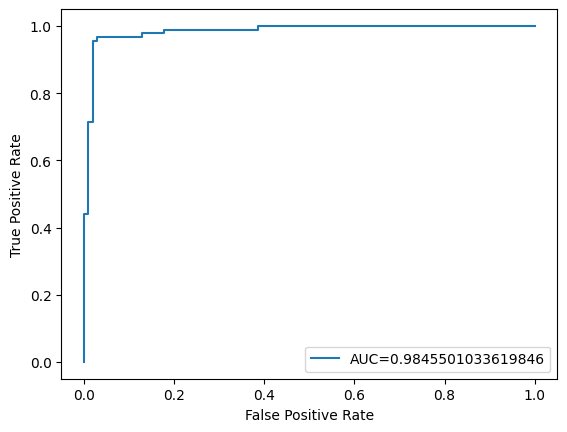

In [ ]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_true,  y_prob)
auc = metrics.roc_auc_score(y_true,  y_prob)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()



In [ ]:
pip install sklearn.metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_true, y_pred, target_names = class_names))

              precision    recall  f1-score   support

    cataract       0.97      0.89      0.93       101
      normal       0.89      0.97      0.93        91

    accuracy                           0.93       192
   macro avg       0.93      0.93      0.93       192
weighted avg       0.93      0.93      0.93       192



Text(0.5, 1.0, 'Confusion Matrix')

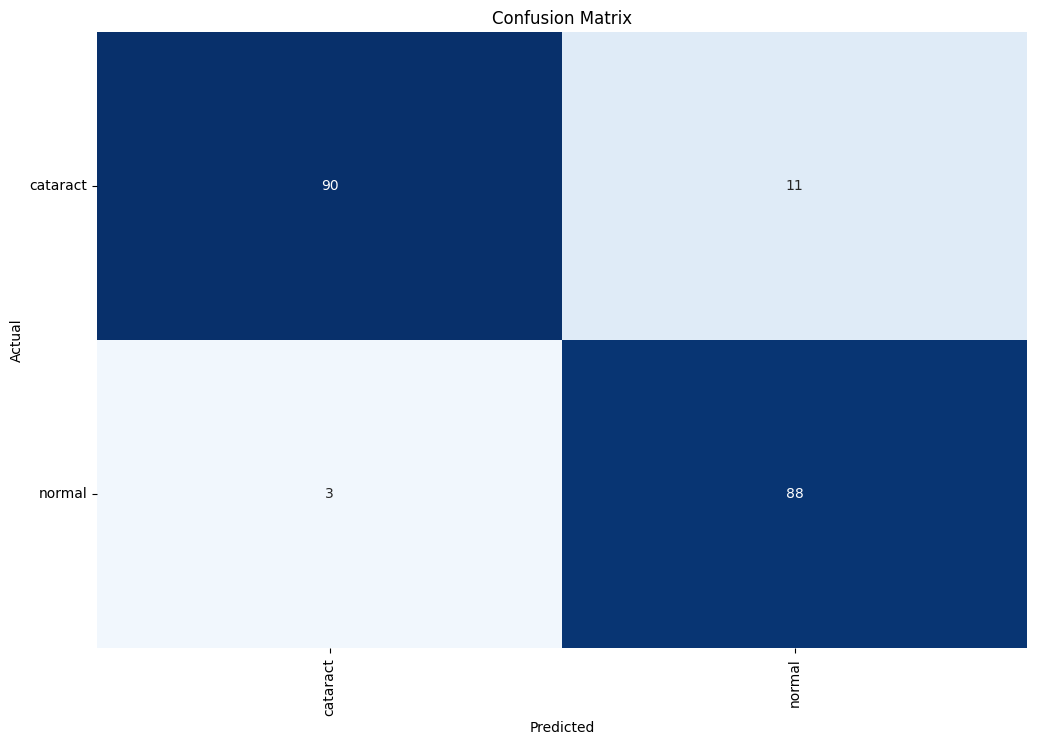

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(2)+.5, class_names, rotation=90)
plt.yticks(np.arange(2)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [ ]:
sensitivity = np.diag(cm)/np.sum(cm,axis=1)
specificity = []
for i in range(cm.shape[0]):
  tn = np.delete(cm, i ,axis=0)[:,np.delete(np.arange(cm.shape[0]),i)]
  fp = np.delete(cm[i:],i)
  specificity.append(np.sum(tn)/ (np.sum(tn)+np.sum(fp)))

In [ ]:
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)

In [ ]:
print(f'Overall Sensitivity: {overall_sensitivity}')
print(f'Overall Specficity: {overall_specificity}')

Overall Sensitivity: 0.9290610379719291
Overall Specficity: 0.7154499151103566
